  Using cached librosa-0.11.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata (16 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 9.7 MB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------------------------------ --------- 2.1/2.7 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 10.6 MB/s  0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   -- ------------------------------------- 2.1/38.1 MB 11.7 MB/s eta 0:00:04
   ---- ----------------------------------- 4.5/38.1 MB 11.2 MB/s eta 0:00:04
   ------- -------------------------------- 6.8/38.1 MB 11.0 MB/s eta 0:00:03
   --------- ------------------------------ 9.2/38.1 MB 11.0 MB/s eta 0:00:03
   ----------- ---------------------------- 11.3/

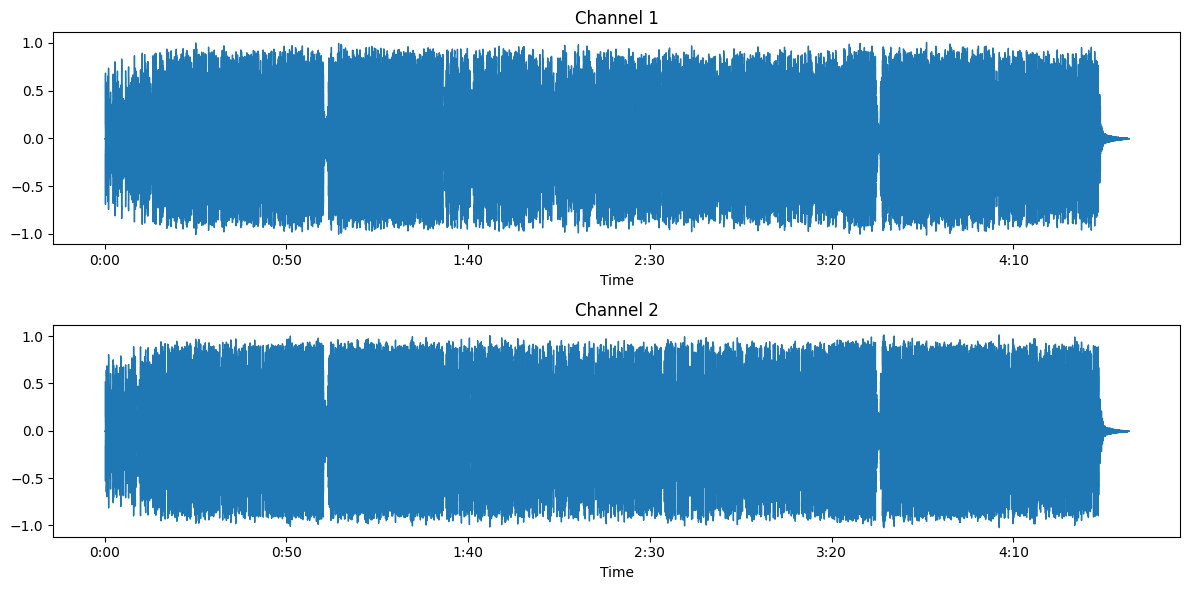

Original channels spectrograms:


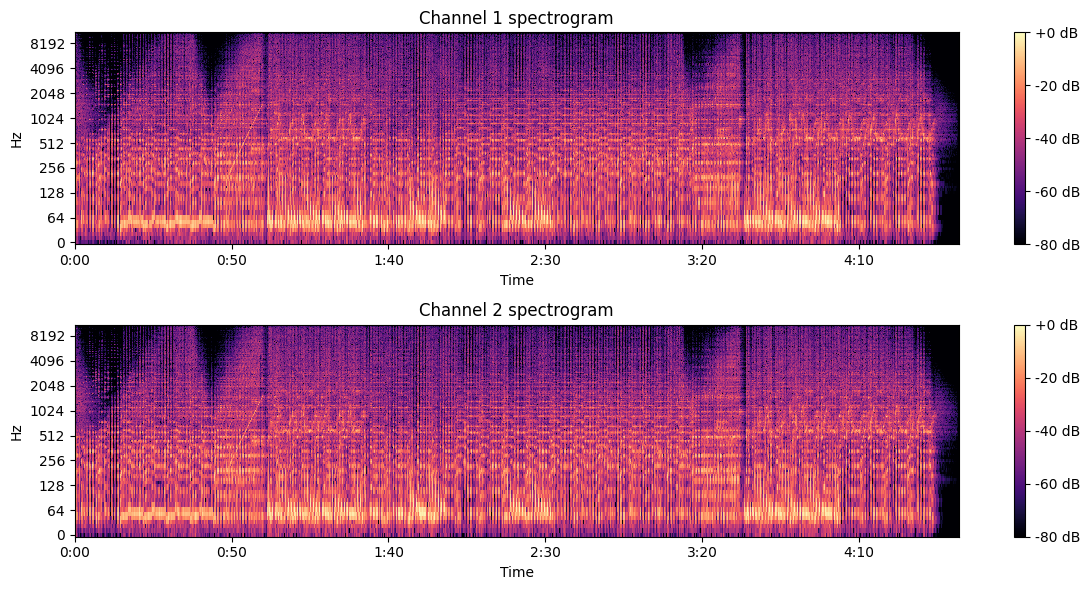

Using recorded channels as mixtures. mixtures shape: (6213632, 2)


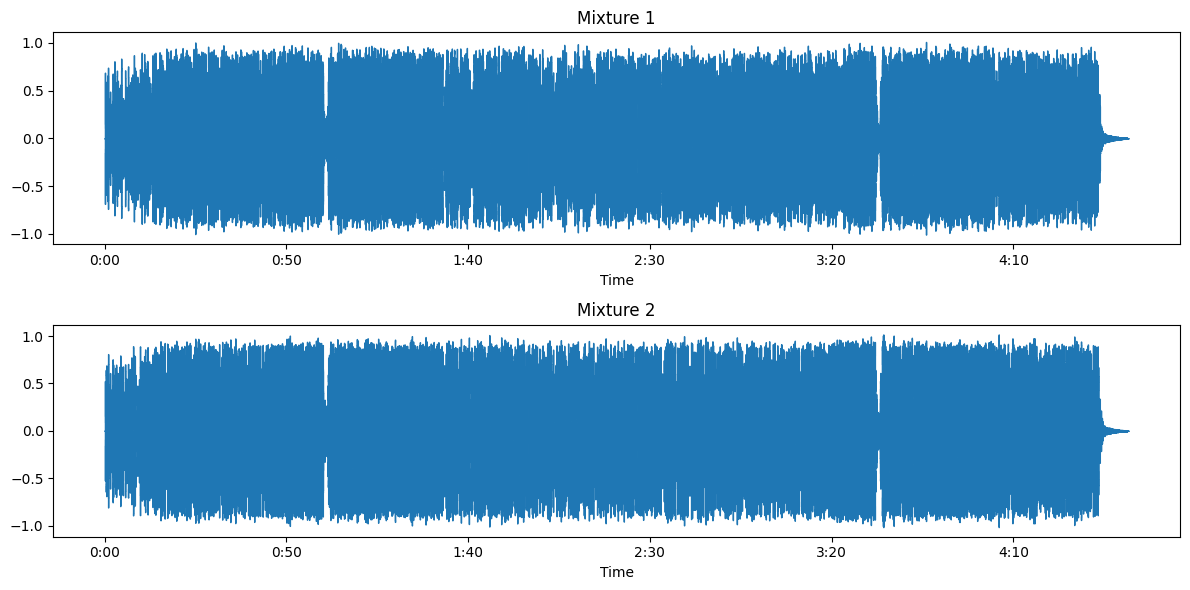

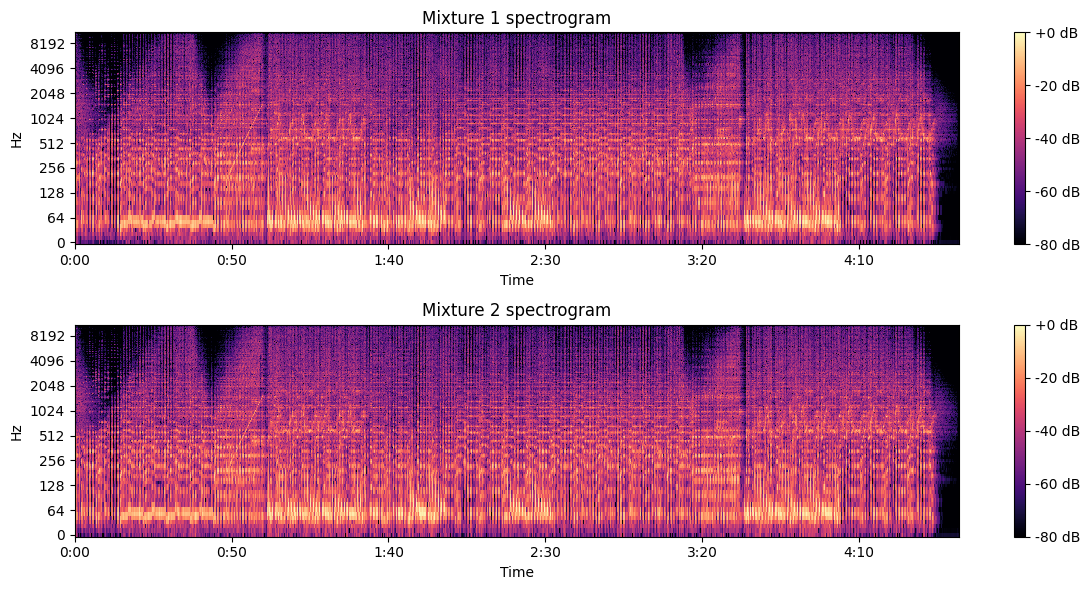

Running FastICA with n_components = 2
ICA done. sources shape: (6213632, 2)
Saved ICA component 1 -> ica_outputs\ica_component_1.wav
Saved ICA component 2 -> ica_outputs\ica_component_2.wav
Running PCA for comparison (n_components = 2 )
Saved PCA component 1 -> ica_outputs\pca_component_1.wav
Saved PCA component 2 -> ica_outputs\pca_component_2.wav


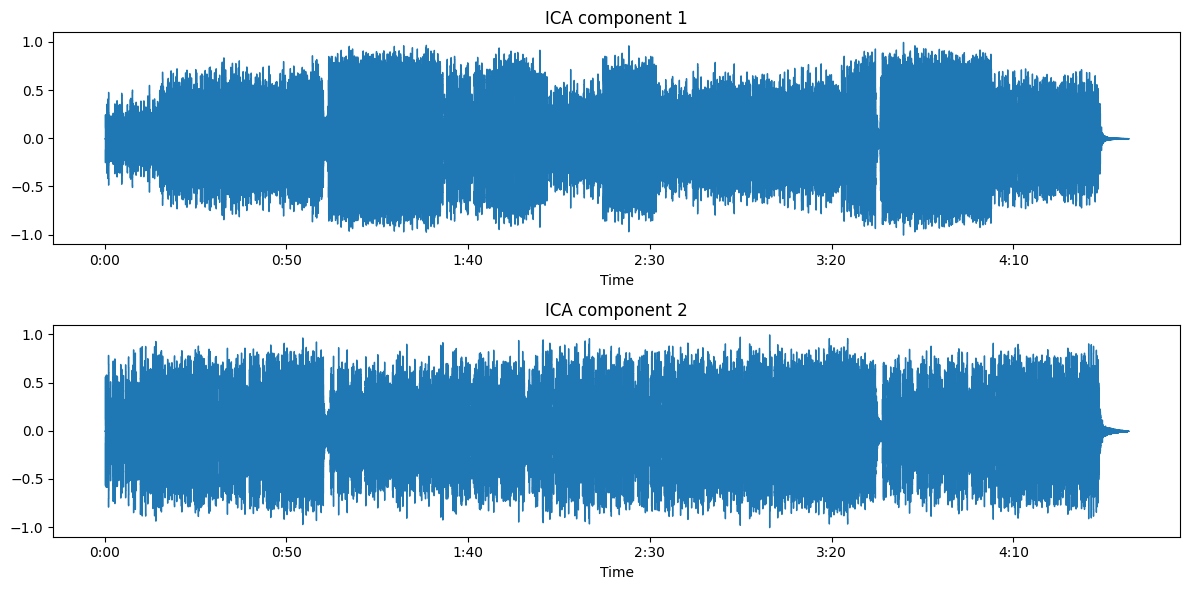

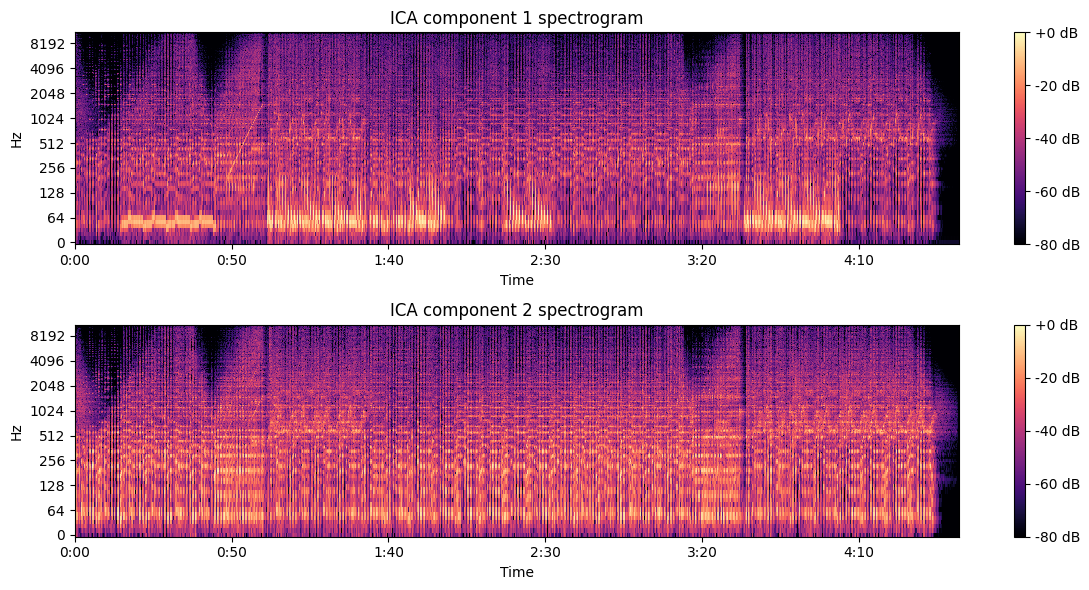

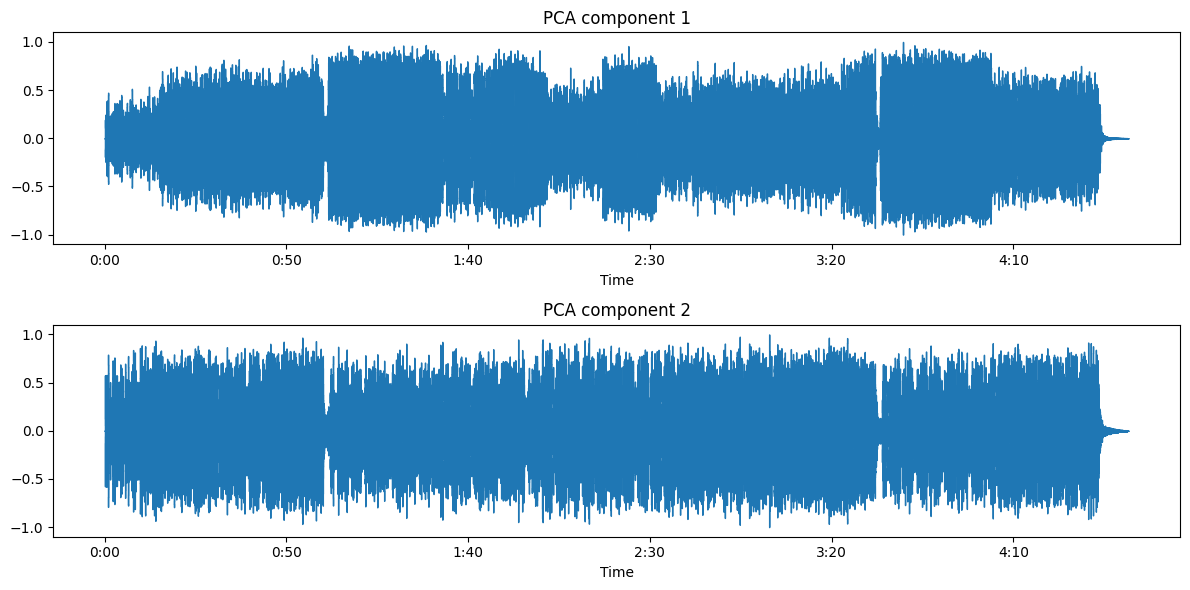

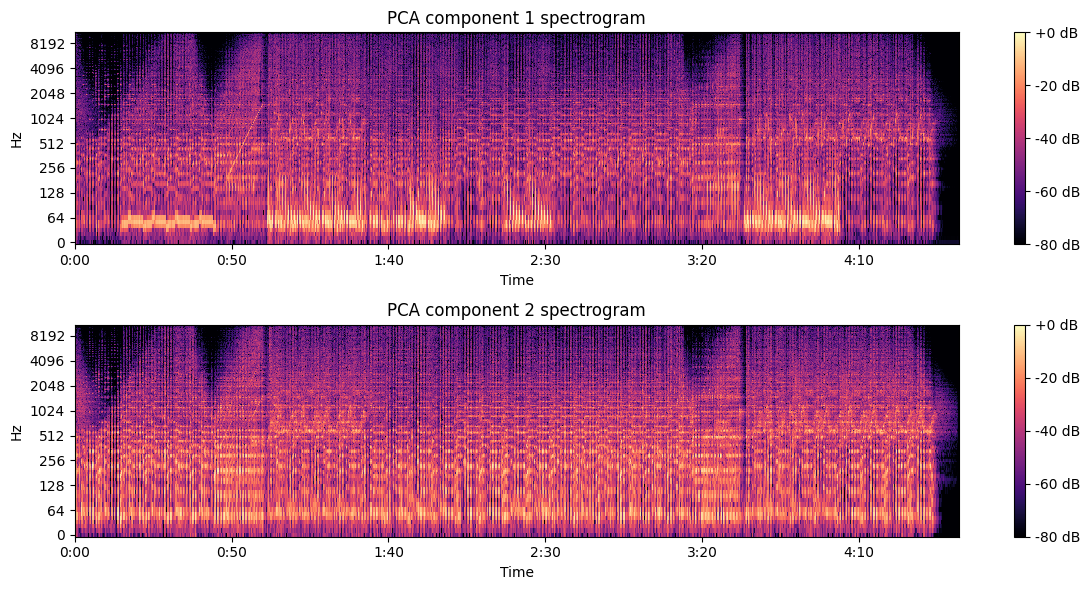


RMS energy (ICA components):
ICA comp 1: RMS = 0.191664
ICA comp 2: RMS = 0.142236

RMS energy (PCA components):
PCA comp 1: RMS = 0.192324
PCA comp 2: RMS = 0.142592

Finished. Check the ica_outputs folder for ICA and PCA component WAV files.
Reminder: separation quality depends heavily on the number of real mixtures and the nature of the recording.


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from sklearn.decomposition import FastICA, PCA
from scipy.signal import butter, lfilter, fftconvolve

# %%
# ----- Utility functions -----

def plot_waveforms(signals, sr, titles=None, figsize=(12, 3)):
    n = len(signals)
    plt.figure(figsize=(figsize[0], figsize[1]*n))
    for i, s in enumerate(signals):
        plt.subplot(n, 1, i+1)
        librosa.display.waveshow(s, sr=sr)
        if titles:
            plt.title(titles[i])
    plt.tight_layout()
    plt.show()


def plot_spectrograms(signals, sr, titles=None, n_fft=2048, hop_length=512, figsize=(12, 3)):
    n = len(signals)
    plt.figure(figsize=(figsize[0], figsize[1]*n))
    for i, s in enumerate(signals):
        S = np.abs(librosa.stft(s, n_fft=n_fft, hop_length=hop_length))
        S_db = librosa.amplitude_to_db(S, ref=np.max)
        plt.subplot(n, 1, i+1)
        librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
        if titles:
            plt.title(titles[i])
        plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()


def normalize_audio(x):
    x = x / (np.max(np.abs(x)) + 1e-9)
    return x


def bandpass_filter(signal, sr, lowcut, highcut, order=4):
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, signal)
    return y

# %%
# ----- Parameters -----
# Path to your wav file. Change this to the file you want to analyze.
AUDIO_PATH = 'input_song.wav'  # <-- replace with your WAV file path
OUTPUT_DIR = 'ica_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

TARGET_SR = 22050  # resample rate
N_COMPONENTS = 2   # number of components (adjust based on mixtures available)

# %%
# ----- Load audio -----
if not os.path.exists(AUDIO_PATH):
    raise FileNotFoundError(f"File not found. Put your audio file at: {AUDIO_PATH}")

y, sr = librosa.load(AUDIO_PATH, sr=TARGET_SR, mono=False)
print('Loaded:', AUDIO_PATH, 'sr:', sr, 'shape:', np.shape(y))

# If y is 2D and shape[0]==2, it's stereo (2 channels) from librosa when mono=False
if y.ndim == 1:
    # Mono file
    is_mono = True
    n_samples = y.shape[0]
else:
    # Multi-channel: librosa returns shape (channels, samples)
    is_mono = False
    n_samples = y.shape[1]

print('Mono?' , is_mono, 'n_samples:', n_samples)

# %%
# ----- Visualize original -----
if is_mono:
    print('Original mono waveform:')
    plot_waveforms([y], sr, titles=['Original (mono)'])
    plot_spectrograms([y], sr, titles=['Original (mono) spectrogram'])
else:
    ch_signals = [y[i, :] for i in range(y.shape[0])]
    titles = [f'Channel {i+1}' for i in range(len(ch_signals))]
    print('Original channels waveforms:')
    plot_waveforms(ch_signals, sr, titles=titles)
    print('Original channels spectrograms:')
    plot_spectrograms(ch_signals, sr, titles=[t + ' spectrogram' for t in titles])

# %%
# ----- Prepare mixture matrix -----
# mixtures matrix shape: (n_samples, n_mixtures)
if not is_mono and y.shape[0] >= N_COMPONENTS:
    # Use first N_COMPONENTS channels as mixtures
    mixtures = y[:N_COMPONENTS, :].T.astype(np.float64)
    print('Using recorded channels as mixtures. mixtures shape:', mixtures.shape)
else:
    # Mono or not enough channels: create synthetic mixtures from single channel
    print('Creating synthetic mixtures from mono audio...')
    s = y if is_mono else y[0, :]
    # Create two (or N_COMPONENTS) mixtures using different bandpass filters and small delays
    mixtures_list = []
    # design frequency bands for filters (example for 2 components)
    bands = [(50, 8000), (200, 11025)]
    # if N_COMPONENTS > len(bands), generate variations using delays + filtering
    for i in range(N_COMPONENTS):
        low, high = bands[i % len(bands)]
        filtered = bandpass_filter(s, sr, low, high, order=6)
        # add small delay via convolution with short kernel
        delay = int(0.001 * sr * (i))  # 1 ms * i
        if delay > 0:
            kernel = np.zeros(delay + 1)
            kernel[-1] = 1.0
            filtered = fftconvolve(filtered, kernel, mode='same')
        mixtures_list.append(filtered)
    mixtures = np.vstack(mixtures_list).T.astype(np.float64)
    print('Synthetic mixtures created. mixtures shape:', mixtures.shape)

# optional: center
mixtures = mixtures - np.mean(mixtures, axis=0)

# plot mixtures
mix_titles = [f'Mixture {i+1}' for i in range(mixtures.shape[1])]
plot_waveforms([mixtures[:, i] for i in range(mixtures.shape[1])], sr, titles=mix_titles)
plot_spectrograms([mixtures[:, i] for i in range(mixtures.shape[1])], sr, titles=[t + ' spectrogram' for t in mix_titles])

# %%
# ----- Apply FastICA -----
print('Running FastICA with n_components =', N_COMPONENTS)
ica = FastICA(n_components=N_COMPONENTS, random_state=0, max_iter=2000)
# sklearn expects shape (n_samples, n_features) -> we have that already
S_ = ica.fit_transform(mixtures)  # Reconstructed sources, shape (n_samples, n_components)
A_ = ica.mixing_  # Estimated mixing matrix
print('ICA done. sources shape:', S_.shape)

# Normalize separated sources
S_norm = np.zeros_like(S_)
for i in range(S_.shape[1]):
    S_norm[:, i] = normalize_audio(S_[:, i])

# Save separated components to wav
for i in range(S_norm.shape[1]):
    out_path = os.path.join(OUTPUT_DIR, f'ica_component_{i+1}.wav')
    sf.write(out_path, S_norm[:, i], sr)
    print('Saved ICA component', i+1, '->', out_path)

# %%
# ----- Apply PCA for comparison -----
print('Running PCA for comparison (n_components =', N_COMPONENTS, ')')
pca = PCA(n_components=N_COMPONENTS)
P_ = pca.fit_transform(mixtures)  # shape (n_samples, n_components)

P_norm = np.zeros_like(P_)
for i in range(P_.shape[1]):
    P_norm[:, i] = normalize_audio(P_[:, i])

for i in range(P_norm.shape[1]):
    out_path = os.path.join(OUTPUT_DIR, f'pca_component_{i+1}.wav')
    sf.write(out_path, P_norm[:, i], sr)
    print('Saved PCA component', i+1, '->', out_path)

# %%
# ----- Visualize separated components -----
ica_titles = [f'ICA component {i+1}' for i in range(S_norm.shape[1])]
plot_waveforms([S_norm[:, i] for i in range(S_norm.shape[1])], sr, titles=ica_titles)
plot_spectrograms([S_norm[:, i] for i in range(S_norm.shape[1])], sr, titles=[t + ' spectrogram' for t in ica_titles])

pca_titles = [f'PCA component {i+1}' for i in range(P_norm.shape[1])]
plot_waveforms([P_norm[:, i] for i in range(P_norm.shape[1])], sr, titles=pca_titles)
plot_spectrograms([P_norm[:, i] for i in range(P_norm.shape[1])], sr, titles=[t + ' spectrogram' for t in pca_titles])

# %%
# ----- Quick evaluation (energy-based) -----
# Print RMS energy of each extracted component as a simple rough indicator
import librosa.feature as lf

print('\nRMS energy (ICA components):')
for i in range(S_norm.shape[1]):
    rms = np.sqrt(np.mean(S_norm[:, i]**2))
    print(f'ICA comp {i+1}: RMS = {rms:.6f}')

print('\nRMS energy (PCA components):')
for i in range(P_norm.shape[1]):
    rms = np.sqrt(np.mean(P_norm[:, i]**2))
    print(f'PCA comp {i+1}: RMS = {rms:.6f}')

# %%
# Done. The separated audio files are in the output directory.
print('\nFinished. Check the', OUTPUT_DIR, 'folder for ICA and PCA component WAV files.')
print('Reminder: separation quality depends heavily on the number of real mixtures and the nature of the recording.')
